In [3]:
import os
import subprocess

In [4]:
src_dir = r"E:\GIS Data\FoxCreek_LiDAR\FoxCreek_58-25-W5\point_cloud_las"
las_files = [f for f in os.listdir(src_dir) if f.split(".")[1] == "las"]

In [5]:
las_tools_bin = r"C:\Program Files\LAStools\bin"
las_info = os.path.join(las_tools_bin, "lasinfo.exe")

In [54]:
info_files = []

for file in las_files:
    name = file.split(".")[0]
    txt_file = name + ".txt"
    if not os.path.exists(os.path.join(src_dir, txt_file)):
        cmd = [
          las_info,
          "-i",
          os.path.join(src_dir, file),
          "-otxt",
          "-odir",
          src_dir,
          "-cd",
          "-histo",
          "classification",
          "1",
        ]
        subprocess.run(cmd)
        print(f"Done with {file}")
    info_files.append(txt_file)

In [55]:
min_header = "min x y z:"
max_header = "max x y z:"

extents = []

def get_value_by_header(line, header):
    index = line.find(header)
    if index == -1:
        return None
    return tuple(float(v) for v in line[index+len(header):].strip().split(" "))

for file in info_files:
    with open(os.path.join(src_dir, file), 'r') as info:
        extent = {"file": file, "min": [], "max": []}
        for line in info:
            min_value = get_value_by_header(line, min_header)
            if min_value:
                extent["min"] = min_value
            else:
                max_value = get_value_by_header(line, max_header)
                if max_value:
                    extent["max"] = max_value
        extents.append(extent)

In [56]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

projection = "EPSG:2955" # NAD83 CSRS UTM 11N
polygons = []
for e in extents:
    bottom_left = (e["min"][0], e["min"][1])
    top_left = (e["min"][0], e["max"][1])
    top_right = (e["max"][0], e["max"][1])
    bottom_right = (e["max"][0], e["min"][1])
    polygon = Polygon([bottom_left, top_left, top_right, bottom_right])
    polygons.append(polygon)

df = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polygons), crs=projection)

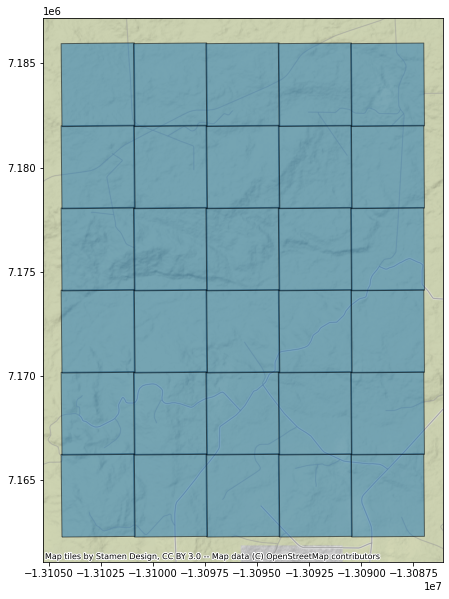

In [67]:
import contextily as ctx
df = df.to_crs(epsg=3857)
ax = df.plot(figsize=(10,10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, )#source=ctx.providers.Esri.WorldImagery, zoom=7)
# ctx.providers.Esri.keys()